# GLM in PyMC3: Out-Of-Sample Predictions

In this notebook I explore the [glm](https://docs.pymc.io/api/glm.html) module of [PyMC3](https://docs.pymc.io/). I am particularly interested in the model definition using [patsy](https://patsy.readthedocs.io/en/latest/) formulas, as it makes the model evaluation loop faster (easier to include features and/or interactions). There are many good resources on this subject, but most of them evaluate the model in-sample. For many applications we require doing predictions on out-of-sample data. This experiment was motivated by the discussion of the thread ["Out of sample" predictions with the GLM sub-module](https://discourse.pymc.io/t/out-of-sample-predictions-with-the-glm-sub-module/773) on the (great!) forum [discourse.pymc.io/](https://discourse.pymc.io/), thank you all for your input!

**Resources**


- [PyMC3 Docs: Example Notebooks](https://docs.pymc.io/nb_examples/index.html)
    
    - In particular check [GLM: Logistic Regression](https://docs.pymc.io/notebooks/GLM-logistic.html)

- [Bambi](https://bambinos.github.io/bambi/), a more complete implementation of the GLM submodule which also allows for mixed-effects models.

- [Bayesian Analysis with Python (Second edition) - Chapter 4](https://github.com/aloctavodia/BAP/blob/master/code/Chp4/04_Generalizing_linear_models.ipynb)
- [Statistical Rethinking](https://xcelab.net/rm/statistical-rethinking/)

## Prepare Notebook

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

from formulae import design_matrices

print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.11.2


In [2]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

## Generate Sample Data

We want to fit a logistic regression model where there is a multiplicative interaction between two numerical features.

In [3]:
# Number of data points.
n = 250
# Create features.
x1 = rng.normal(loc=0.0, scale=2.0, size=n)
x2 = rng.normal(loc=0.0, scale=2.0, size=n)
epsilon = rng.normal(loc=0.0, scale=0.5, size=n)
# Define target variable.
intercept = -0.5
beta_x1 = 1
beta_x2 = -1
beta_interaction = 2
z = intercept + beta_x1 * x1 + beta_x2 * x2 + beta_interaction * x1 * x2
p = 1 / (1 + np.exp(-z))
y = rng.binomial(n=1, p=p, size=n)

df = pd.DataFrame(dict(x1=x1, x2=x2, y=y))

df.head()

,x1,x2,y
0,-0.445284,1.381325,0
1,2.651317,0.800736,1
2,-1.141940,-0.128204,0
3,1.336498,-0.931965,0
4,2.290762,3.400222,1


Let us do some exploration of the data:

/home/ada/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


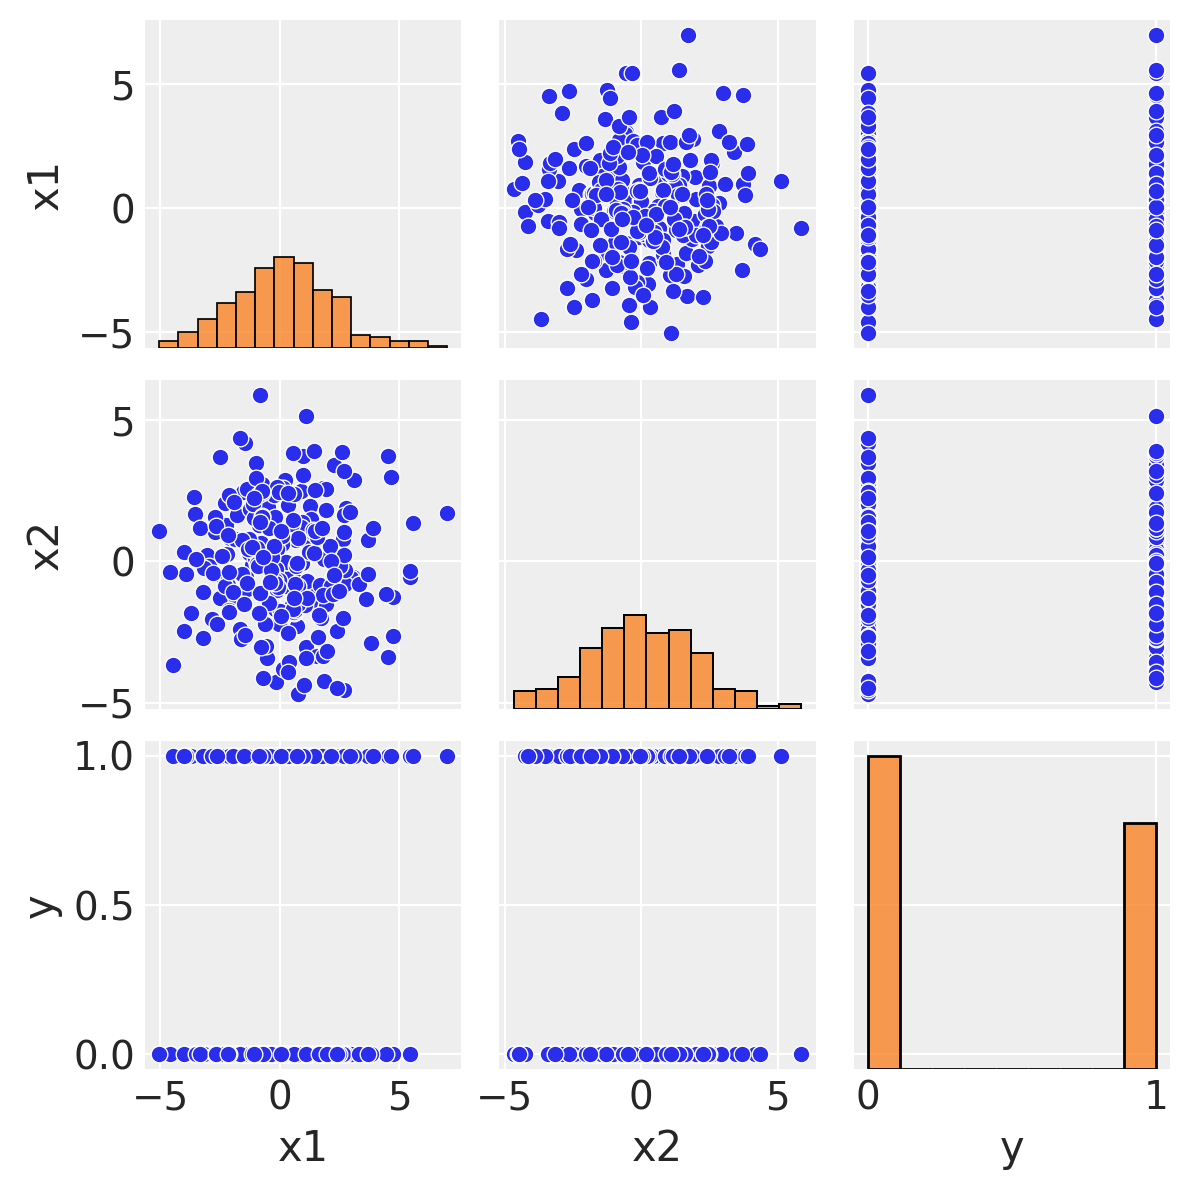

In [4]:
sns.pairplot(data=df, kind="scatter", height=2, plot_kws={"color": "C0"}, diag_kws={"color": "C1"});

- $x_1$ and $x_2$ are not correlated.
- $x_1$ and $x_2$ do not seem to separate the $y$-classes independently.
- The distribution of $y$ is not highly unbalanced.

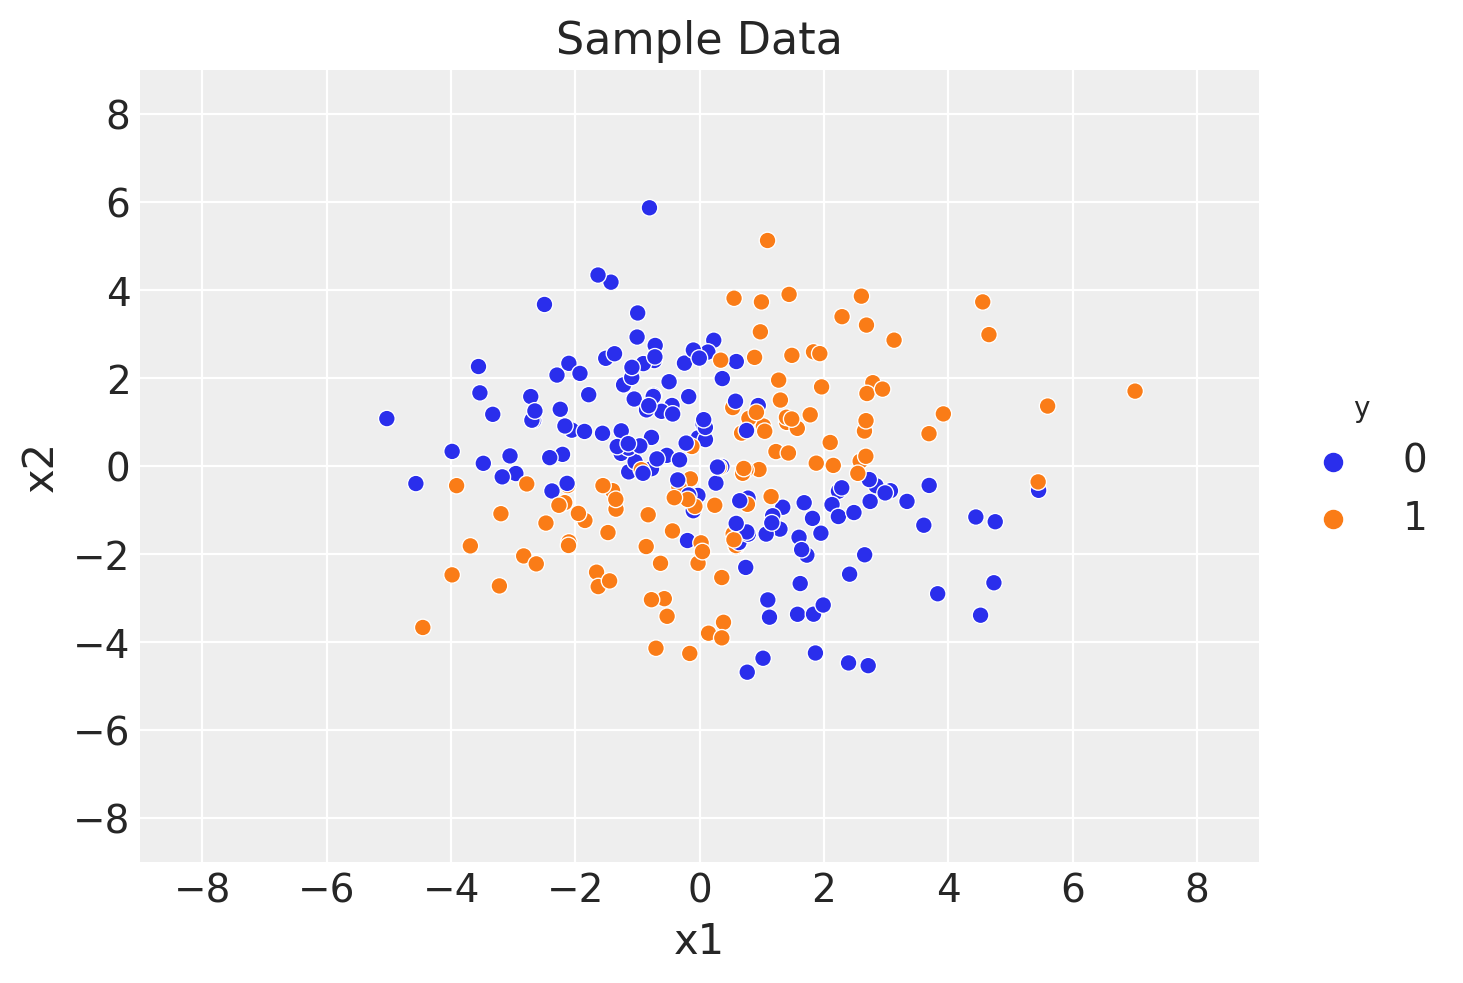

In [5]:
fig, ax = plt.subplots()
sns.scatterplot(x="x1", y="x2", data=df, hue="y", palette=["C0", "C1"])
ax.legend(title="y", loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Sample Data", xlim=(-9, 9), ylim=(-9, 9));

## Prepare Data for Modeling

I created the features from a formula using [formulae](https://patsy.readthedocs.io/en/latest/) directly and then use  (this was motivated by going into the [source code](https://github.com/pymc-devs/pymc3/blob/master/pymc3/glm/linear.py)).

In [6]:
# Define model formula.
formula = "y ~ x1 * x2"
# Create features.
dm = design_matrices("y ~ x1 * x2", data=df)

y, x = dm.response.design_vector.flatten(), dm.common.design_matrix
labels = list(dm.common.terms_info.keys())

As pointed out on the [thread](https://discourse.pymc.io/t/out-of-sample-predictions-with-the-glm-sub-module/773) (thank you @Nicky!), we need to keep the labels of the features in the design matrix.

In [7]:
print(f"labels = {labels}")

labels = ['Intercept', 'x1', 'x2', 'x1:x2']


Now we do a train-test split.

In [8]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=RANDOM_SEED)

data = pd.concat(
    [pd.DataFrame(x_train, columns=labels), pd.DataFrame(y_train, columns=["y"])], axis=1
)

## Define and Fit the Model

We now specify the model in PyMC3.

In [9]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sd=10),
    "x1": bmb.Prior("Normal", mu=0, sd=10),
    "x2": bmb.Prior("Normal", mu=0, sd=10),
    "x1:x2": bmb.Prior("Normal", mu=0, sd=10),
}

model = bmb.Model(formula=formula, data=data, family="bernoulli", priors=priors)
trace = model.fit(draws=5000, chains=5, tune=1000, target_accept=0.87, random_seed=RANDOM_SEED)

Modeling the probability that y==1
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 4 jobs)
NUTS: [Intercept, x1:x2, x2, x1]


Sampling 5 chains for 1_000 tune and 5_000 draw iterations (5_000 + 25_000 draws total) took 19 seconds.


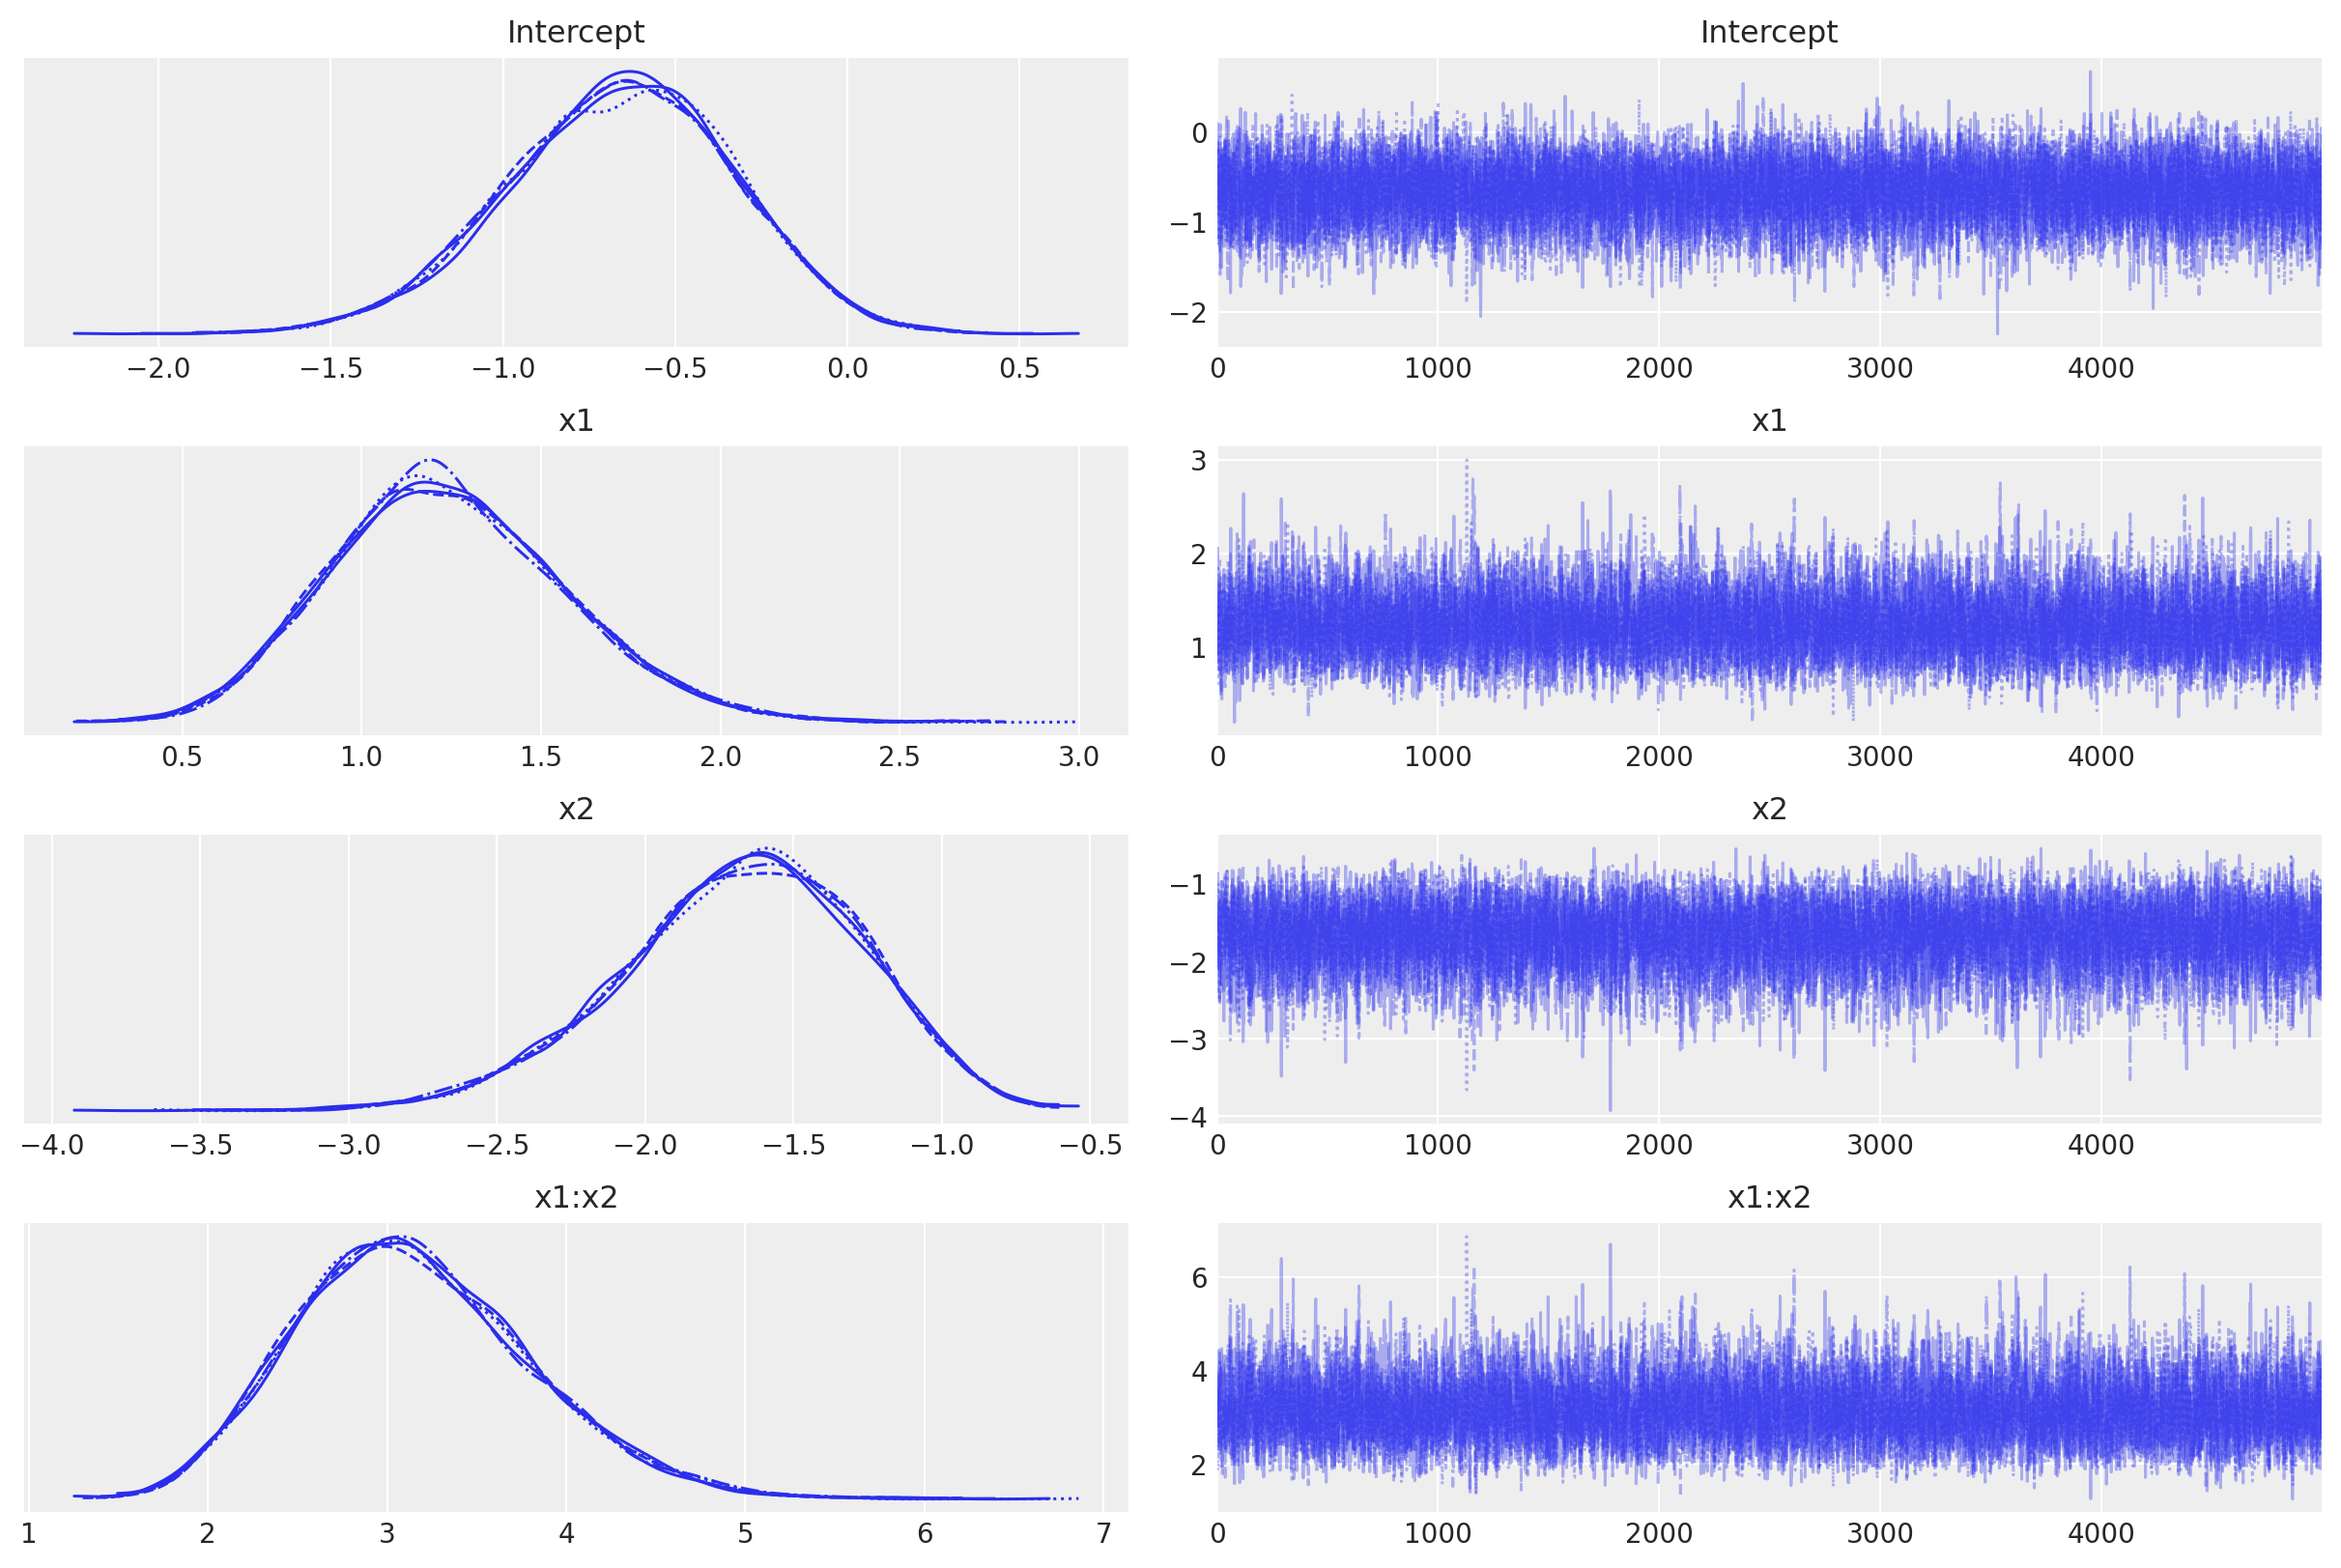

In [10]:
# Plot chains.
az.plot_trace(trace);

In [11]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.662,0.331,-1.283,-0.050,0.003,0.002,10097.0,12559.0,1.0
x1,1.245,0.326,0.638,1.850,0.004,0.003,7246.0,9039.0,1.0
x2,-1.677,0.407,-2.457,-0.950,0.005,0.004,7075.0,9169.0,1.0
x1:x2,3.152,0.655,1.960,4.366,0.008,0.006,6701.0,8157.0,1.0


The chains look good.

## Generate Out-Of-Sample Predictions

Now we generate predictions on the test set.

In [12]:
# Generate posterior samples.
model.predict(trace, kind="pps", data=pd.DataFrame(x_test, columns=labels), draws=1000)

In [13]:
# Compute the point prediction by taking the mean
# and defining the category via a threshold.
p_test_pred = trace.posterior_predictive["y"].mean(("chain", "draw")).values
y_test_pred = (p_test_pred >= 0.5).astype("int")

## Evaluate Model

First let us compute the accuracy on the test set.

In [14]:
from sklearn.metrics import accuracy_score

print(f"accuracy = {accuracy_score(y_true=y_test, y_pred=y_test_pred): 0.3f}")

accuracy =  0.947


Next, we plot the [roc curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) and compute the [auc](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve).

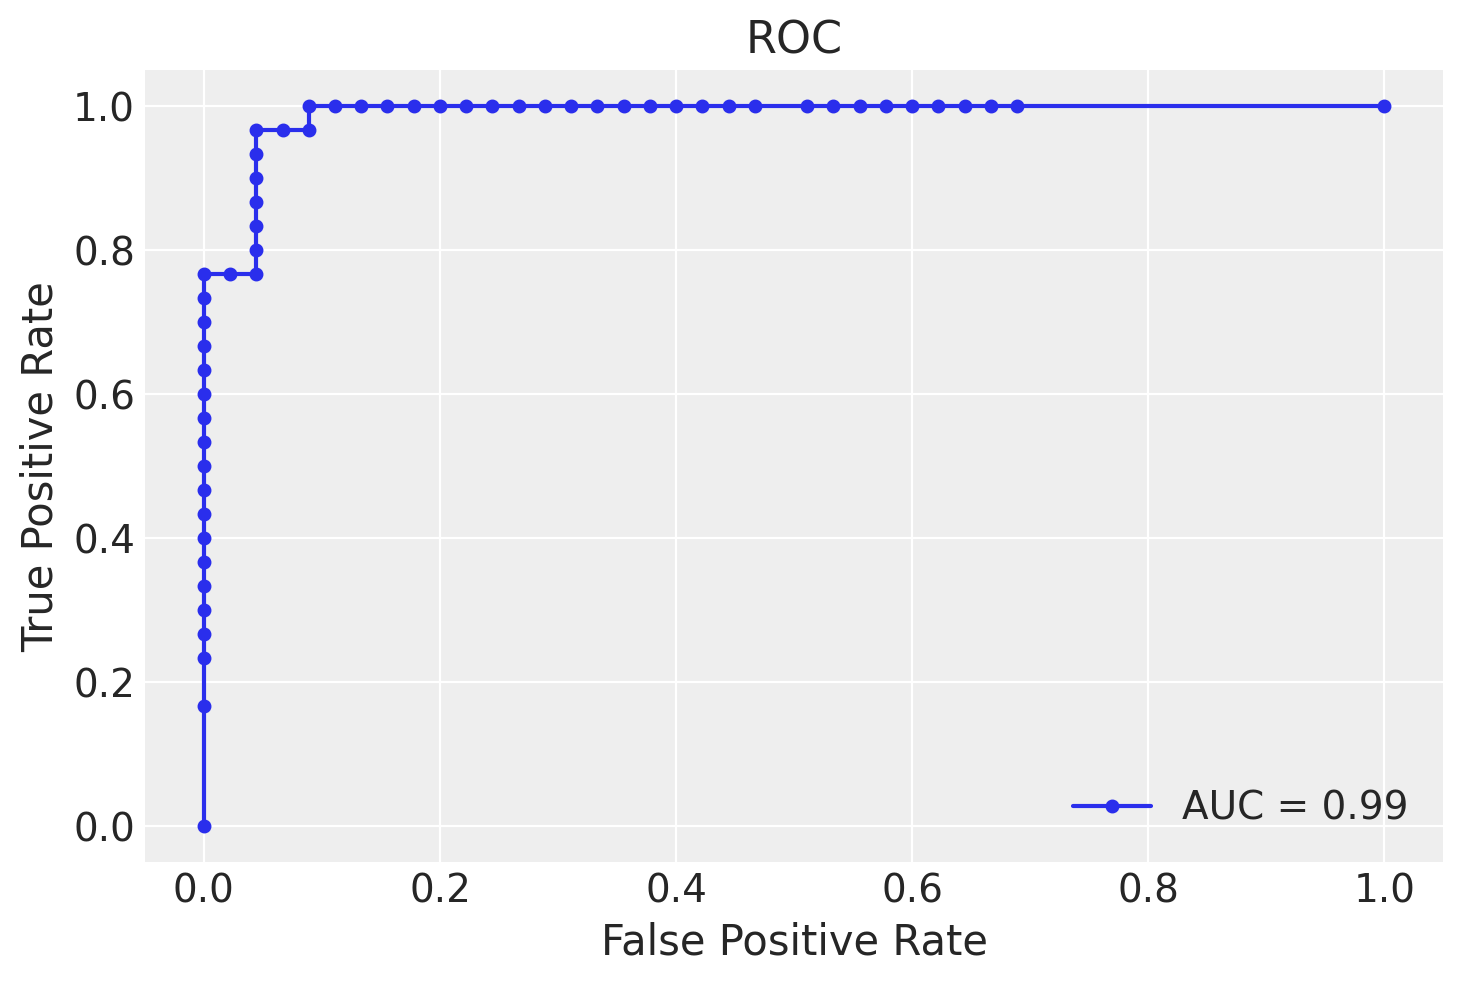

In [15]:
from sklearn.metrics import RocCurveDisplay, auc, roc_curve

fpr, tpr, thresholds = roc_curve(
    y_true=y_test, y_score=p_test_pred, pos_label=1, drop_intermediate=False
)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots()
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc_display = roc_display.plot(ax=ax, marker="o", color="C0", markersize=4)
ax.set(title="ROC");

The model is performing as expected (we of course know the data generating process, which is almost never the case in practical applications).

## Model Decision Boundary

Finally we will describe and plot the model decision boundary, which is the space defined as

$$\mathcal{B} = \{(x_1, x_2) \in \mathbb{R}^2 \: | \: p(x_1, x_2) = 0.5\}$$

where $p$ denotes the probability of belonging to the class $y=1$ output by the model. To make this set explicit, we simply write the condition in terms of the model parametrization:

$$0.5 = \frac{1}{1 + \exp(-(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_{12} x_1x_2))}$$

which implies

$$0 = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_{12} x_1x_2$$

Solving for $x_2$ we get the formula

$$x_2 = - \frac{\beta_0 + \beta_1 x_1}{\beta_2 + \beta_{12}x_1}$$

Observe that this curve is a hyperbola centered at the singularity point $x_1 = - \beta_2 / \beta_{12}$.

Let us now plot the model decision boundary using a grid:

In [16]:
# Construct grid.
x1_grid = np.linspace(start=-9, stop=9, num=300)
x2_grid = x1_grid

x1_mesh, x2_mesh = np.meshgrid(x1_grid, x2_grid)

x_grid = np.stack(arrays=[x1_mesh.flatten(), x2_mesh.flatten()], axis=1)

x_grid_ext = design_matrices("x1 * x2", data=pd.DataFrame(dict(x1=x_grid[:, 0], x2=x_grid[:, 1])))

# Generate model predictions on the grid.
model.predict(trace, kind="pps", data=x_grid_ext.common.as_dataframe(), draws=1000)

MemoryError: Unable to allocate 16.8 GiB for an array with shape (90000, 25000) and data type float64

In [17]:
x_grid_ext.common.as_dataframe()

,Intercept,x1,x2,x1:x2
0,1.0,-9.000000,-9.0,81.000000
1,1.0,-8.939799,-9.0,80.458194
2,1.0,-8.879599,-9.0,79.916388
3,1.0,-8.819398,-9.0,79.374582
4,1.0,-8.759197,-9.0,78.832776
...,...,...,...,...
89995,1.0,8.759197,9.0,78.832776
89996,1.0,8.819398,9.0,79.374582
89997,1.0,8.879599,9.0,79.916388
89998,1.0,8.939799,9.0,80.458194


Now we compute the model decision boundary on the grid for visualization purposes. 

In [ ]:
numerator = -(trace["Intercept"].mean(axis=0) + trace["x1"].mean(axis=0) * x1_grid)
denominator = trace["x2"].mean(axis=0) + trace["x1:x2"].mean(axis=0) * x1_grid
bd_grid = numerator / denominator

grid_df = pd.DataFrame(x_grid, columns=["x1", "x2"])
grid_df["p"] = ppc_grid["y"].mean(axis=0)
grid_df.sort_values("p", inplace=True)

p_grid = grid_df.pivot(index="x2", columns="x1", values="p").to_numpy()

We finally get the plot and the predictions on the test set:

In [ ]:
fig, ax = plt.subplots()
cmap = sns.diverging_palette(240, 10, n=50, as_cmap=True)
sns.scatterplot(
    x=x_test[:, 1].flatten(),
    y=x_test[:, 2].flatten(),
    hue=y_test,
    palette=["C0", "C1"],
    ax=ax,
)
sns.lineplot(x=x1_grid, y=bd_grid, color="black", ax=ax)
ax.contourf(x1_grid, x2_grid, p_grid, cmap=cmap, alpha=0.3)
ax.legend(title="y", loc="center left", bbox_to_anchor=(1, 0.5))
ax.lines[0].set_linestyle("dotted")
ax.set(title="Model Decision Boundary", xlim=(-9, 9), ylim=(-9, 9), xlabel="x1", ylabel="x2");

**Remark:** Note that we have computed the model decision boundary by using the mean of the posterior samples. However, we can generate a better (and more informative!) plot if we use the complete distribution (similarly for other metrics like accuracy and auc). One way of doing this is by storing and computing it inside the model definition as a `Deterministic` variable as in [Bayesian Analysis with Python (Second edition) - Chapter 4](https://github.com/aloctavodia/BAP/blob/master/code/Chp4/04_Generalizing_linear_models.ipynb).

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w -p theano,xarray